In [50]:
import networkx as nx
from utils_globals import *
import pickle
import numpy as np
# Install powerlaw if not already installed
#%pip install powerlaw
from utils_network import grow_Barabasi_Albert_graph, compute_network_metrics, plot_degree_distribution_loglog, plot_all_models_loglog, plot_all_models_linear, effective_size
import random
import matplotlib.pyplot as plt
import powerlaw
import warnings
from scipy.stats import poisson, expon, lognorm
from sklearn.linear_model import LinearRegression
# Ignore warnings from powerlaw package
warnings.filterwarnings("ignore")


# Network Metrics

In [20]:
# load graph:
S = pickle.load(open(PICKLE_DIR + "/graph.pkl", "rb"))
S_undirected = pickle.load(open(PICKLE_DIR + "/graph_undirected.pkl", "rb"))
print(f"Number of nodes: {S_undirected.number_of_nodes()}")
print(f"Number of edges: {S_undirected.number_of_edges()}")

n_nodes = S_undirected.number_of_nodes()
n_edges = S_undirected.number_of_edges()

Number of nodes: 1362
Number of edges: 8887


## Comparison to Barabasi-Albert graph

In [4]:
random.seed(RANDOM_STATE)
F_BA = grow_Barabasi_Albert_graph(n=n_nodes, E=n_edges)

Using m = 7 to approximate E = 8887


In [5]:
print(f"Number of nodes: {F_BA.number_of_nodes()}")
print(f"Number of edges: {F_BA.number_of_edges()}")

Number of nodes: 1362
Number of edges: 9506


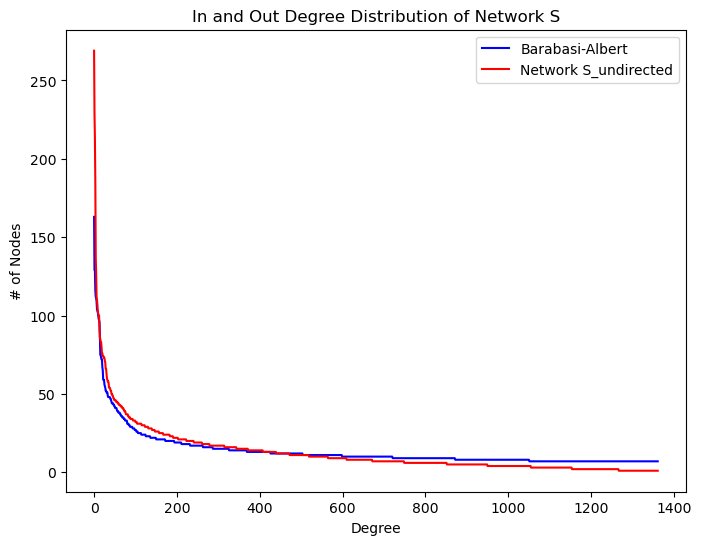

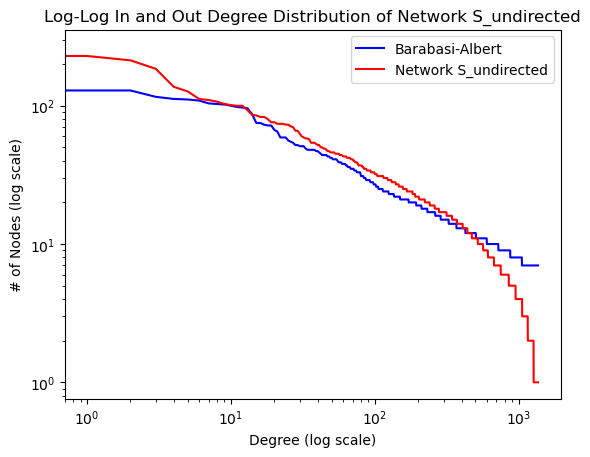

In [6]:
# Plotting the degree distributions
degree_sequence_F_BA = sorted([d for n, d in F_BA.degree()], reverse=True)
degree_sequence_S_undirected = sorted([d for n, d in S_undirected.degree()], reverse=True)

## Plot setup
plt.figure(figsize=(8, 6))

## Plotting the degree distribution as a linear plot
plt.plot(degree_sequence_F_BA, 'b-', label='Barabasi-Albert')
plt.plot(degree_sequence_S_undirected, 'r-', label='Network S_undirected')

plt.xlabel('Degree')
plt.ylabel('# of Nodes')
plt.title('In and Out Degree Distribution of Network S')
plt.legend()
plt.show()


## Plotting the degree distribution as a log-log plot
plt.loglog(degree_sequence_F_BA, 'b-', label='Barabasi-Albert')
plt.loglog(degree_sequence_S_undirected, 'r-', label='Network S_undirected')

plt.xlabel('Degree (log scale)')
plt.ylabel('# of Nodes (log scale)')
plt.title('Log-Log In and Out Degree Distribution of Network S_undirected')
plt.legend()
plt.show()

In [7]:
# Compute metrics for both graphs
wiki_metrics = compute_network_metrics(S_undirected)
ba_metrics = compute_network_metrics(F_BA)

# Compare metrics
print("Philosopher Wikipedia Graph Metrics:")
for key, value in wiki_metrics.items():
    if key not in ['degree_histogram', 'degree_centrality']:
        print(f"{key}: {value:.2f}")
        
print("\nBarabási-Albert Graph Metrics:")
for key, value in ba_metrics.items():
    if key not in ['degree_histogram', 'degree_centrality']:
        print(f"{key}: {value:.2f}")

Philosopher Wikipedia Graph Metrics:
global_clustering: 0.12
average_clustering: 0.28
assortativity: -0.11
num_connected_components: 1.00
largest_component_size: 1362.00
average_shortest_path: 3.06
diameter: 8.00

Barabási-Albert Graph Metrics:
global_clustering: 0.03
average_clustering: 0.04
assortativity: -0.03
num_connected_components: 1.00
largest_component_size: 1362.00
average_shortest_path: 2.82
diameter: 4.00


## Model Fitting

In [9]:
# Step 1: Extract the degree sequence
degrees = np.array([d for n, d in S_undirected.degree()])
print(f"Minimum degree: {np.min(degrees)}")
print(f"Maximum degree: {np.max(degrees)}")

# Step 2: Fit candidate distributions using MLE

# 2a. Poisson Distribution
lambda_poisson = np.mean(degrees)
log_likelihood_poisson = np.sum(poisson.logpmf(degrees, lambda_poisson))

# 2b. Exponential Distribution (continuous approximation)
params_exp = expon.fit(degrees, floc=0)  # Fix loc=0
lambda_exp = 1 / params_exp[1]  # Scale parameter is 1/lambda
log_likelihood_exp = np.sum(expon.logpdf(degrees, *params_exp))

# 2c. Log-Normal Distribution
params_lognorm = lognorm.fit(degrees[degrees > 0], floc=0)  # Exclude zeros
sigma_lognorm, loc_lognorm, scale_lognorm = params_lognorm
log_likelihood_lognorm = np.sum(lognorm.logpdf(degrees[degrees > 0], *params_lognorm))

# 2d. Power-Law Distribution
fit = powerlaw.Fit(degrees, xmin=1)
alpha_powerlaw = fit.power_law.alpha
xmin_powerlaw = fit.power_law.xmin
log_likelihood_powerlaw = fit.power_law.loglikelihoods(degrees).sum()

# Step 3: Compute AIC and BIC for each model
n = len(degrees)

# Poisson
k_poisson = 1  # lambda
AIC_poisson = 2 * k_poisson - 2 * log_likelihood_poisson
BIC_poisson = k_poisson * np.log(n) - 2 * log_likelihood_poisson

# Exponential
k_exp = 1  # lambda
AIC_exp = 2 * k_exp - 2 * log_likelihood_exp
BIC_exp = k_exp * np.log(n) - 2 * log_likelihood_exp

# Log-Normal
n_lognorm = len(degrees[degrees > 0])
k_lognorm = 2  # sigma and scale
AIC_lognorm = 2 * k_lognorm - 2 * log_likelihood_lognorm
BIC_lognorm = k_lognorm * np.log(n_lognorm) - 2 * log_likelihood_lognorm

# Power-Law
n_powerlaw = len(degrees[degrees >= xmin_powerlaw])
k_powerlaw = 2  # alpha and xmin
AIC_powerlaw = 2 * k_powerlaw - 2 * log_likelihood_powerlaw
BIC_powerlaw = k_powerlaw * np.log(n_powerlaw) - 2 * log_likelihood_powerlaw

# Step 4: Select the best-fitting model based on AIC and BIC
AICs = {
    'Poisson': AIC_poisson,
    'Exponential': AIC_exp,
    'Log-Normal': AIC_lognorm,
    'Power-Law': AIC_powerlaw
}

BICs = {
    'Poisson': BIC_poisson,
    'Exponential': BIC_exp,
    'Log-Normal': BIC_lognorm,
    'Power-Law': BIC_powerlaw
}

best_fit_aic = min(AICs, key=AICs.get)
best_fit_bic = min(BICs, key=BICs.get)

# Output results
print("\nModel fitting results:")
print("-----------------------")
print("Log-Likelihoods:")
print(f"-Poisson: {log_likelihood_poisson:.1f}")
print(f"-Exponential: {log_likelihood_exp:.1f}")
print(f"-Log-Normal: {log_likelihood_lognorm:.1f}")
print(f"-Power-Law: {log_likelihood_powerlaw:.1f}")

print(f"\nAIC values:")
for dist, aic in AICs.items():
    print(f"-{dist}: {aic:.2f} {'<- Best fit' if dist == best_fit_aic else ''}")

print(f"\nBIC Values:")
for dist, bic in BICs.items():
    print(f"-{dist}: {bic:.1f} {'<- Best fit' if dist == best_fit_bic else ''}")

print("\nEstimated parameters:")
print("---------------------")
print(f"Poisson lambda: {lambda_poisson:.2f}")
print(f"Exponential lambda: {lambda_exp:.4f}")
print(f"Log-Normal sigma: {sigma_lognorm:.4f}, scale: {scale_lognorm:.2f}")
print(f"Power-Law alpha: {alpha_powerlaw:.2f}, xmin: {xmin_powerlaw}")


Minimum degree: 1
Maximum degree: 269

Model fitting results:
-----------------------
Log-Likelihoods:
-Poisson: -12655.6
-Exponential: -4860.7
-Log-Normal: -4734.4
-Power-Law: -5066.2

AIC values:
-Poisson: 25313.14 
-Exponential: 9723.36 
-Log-Normal: 9472.89 <- Best fit
-Power-Law: 10136.37 

BIC Values:
-Poisson: 25318.4 
-Exponential: 9728.6 
-Log-Normal: 9483.3 <- Best fit
-Power-Law: 10146.8 

Estimated parameters:
---------------------
Poisson lambda: 13.05
Exponential lambda: 0.0766
Log-Normal sigma: 1.0402, scale: 7.52
Power-Law alpha: 1.50, xmin: 1.0


In [10]:
# Step 6: Create Log-Log Plots for Each Model

# Prepare fitted parameters for each model
fitted_models = {
    'Poisson': {'lambda': lambda_poisson},
    'Exponential': {'scale': params_exp[1]},  # scale = 1/lambda
    'Log-Normal': {'sigma': sigma_lognorm, 'loc': loc_lognorm, 'scale': scale_lognorm},
    'Power-Law': {'alpha': alpha_powerlaw, 'xmin': xmin_powerlaw}
}

# # Create separate plots for each model
# for model in ['Poisson', 'Exponential', 'Log-Normal', 'Power-Law']:
#     plot_degree_distribution_loglog(degrees, model, fitted_models[model])

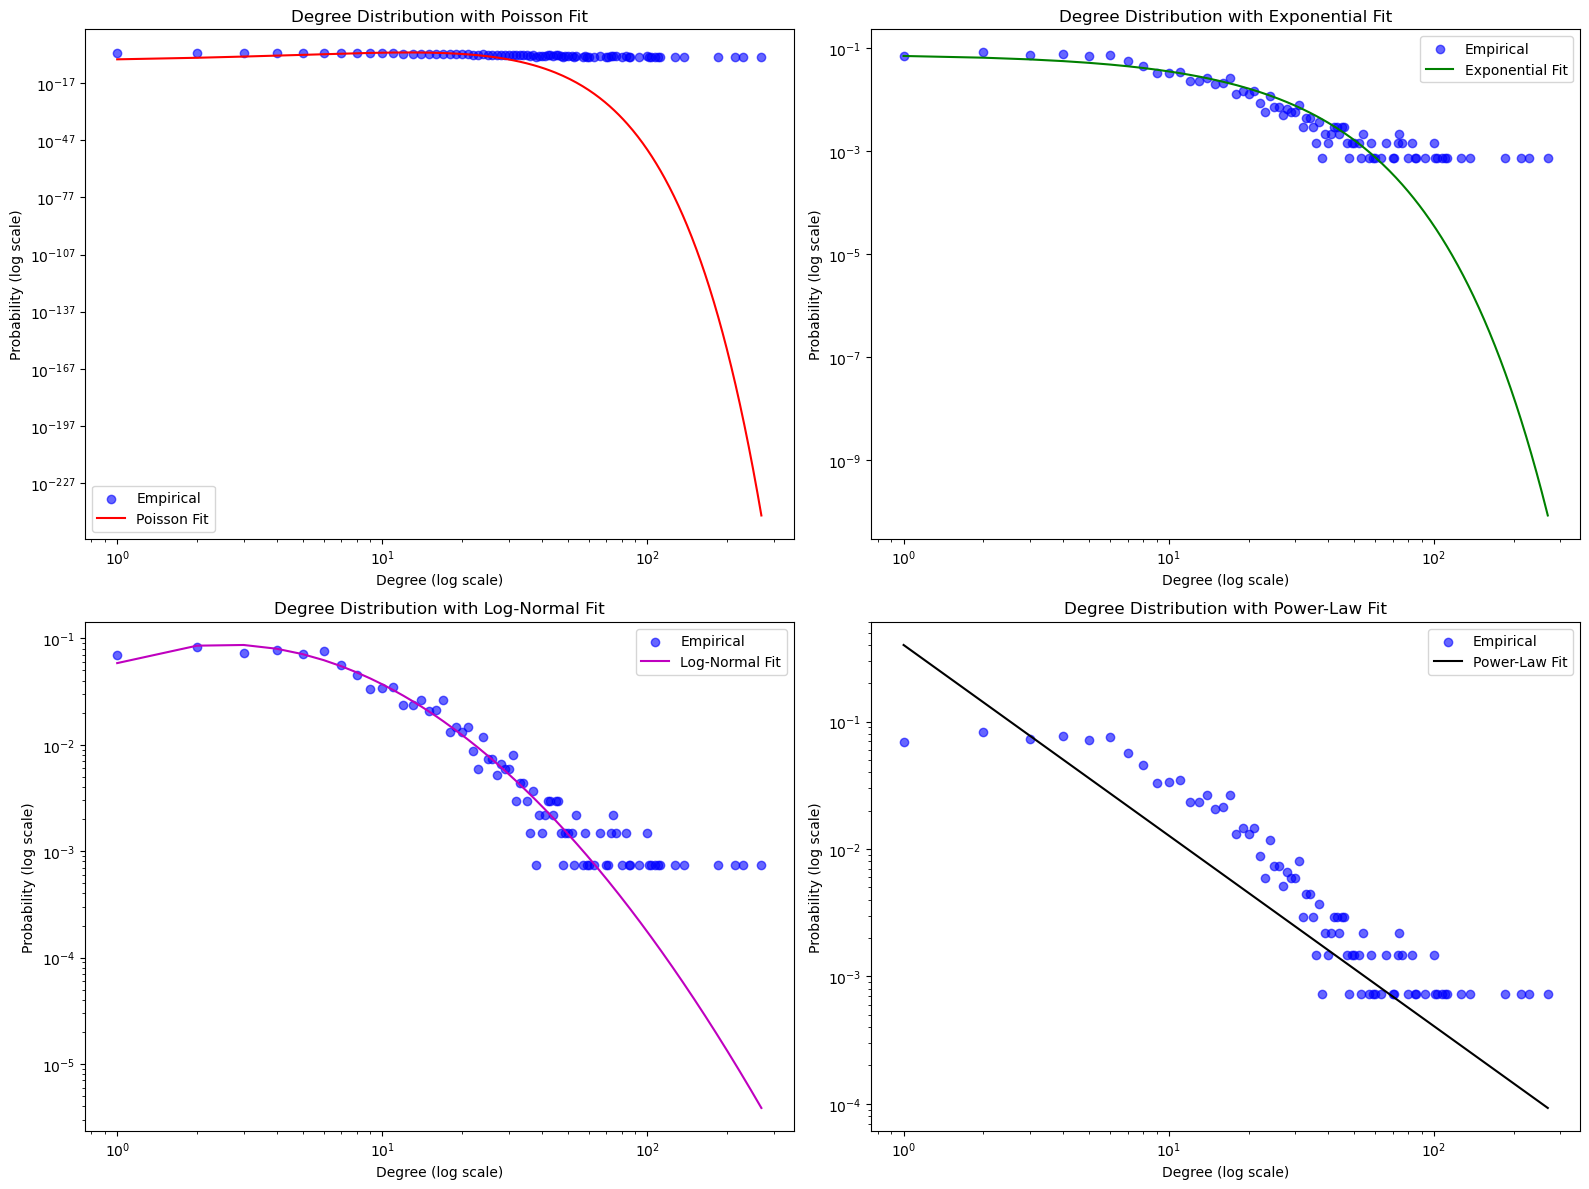

In [11]:
plot_all_models_loglog(degrees, fitted_models)

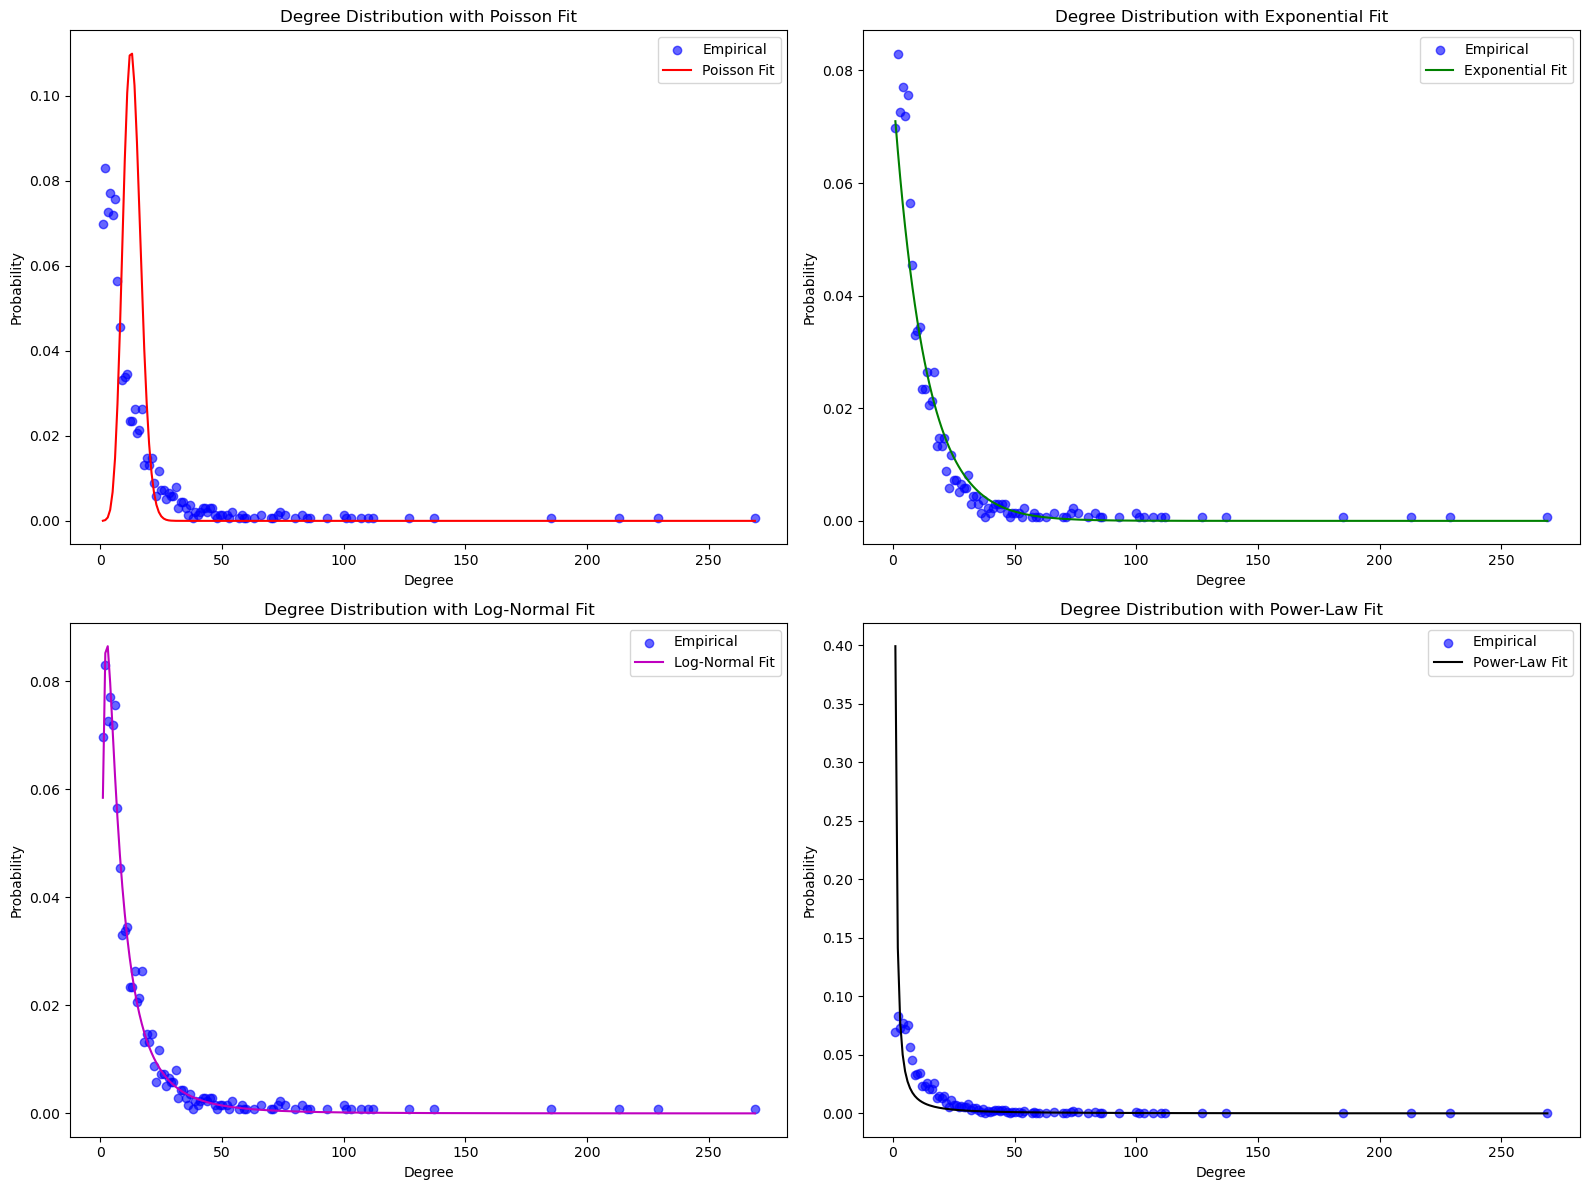

In [12]:
plot_all_models_linear(degrees, fitted_models)

## Nodes Analysis

In [13]:
TOP_N_NODES = 15

In [14]:
# Print the highest degree nodes
sorted_degrees = sorted(S_undirected.degree, key=lambda x: x[1], reverse=True)
print(f"Top {TOP_N_NODES} nodes by degree:")
for node, degree in sorted_degrees[:TOP_N_NODES]:
    print(f"Node: {node}, Degree: {degree}")

Top 15 nodes by degree:
Node: Aristotle, Degree: 269
Node: Immanuel_Kant, Degree: 229
Node: Plato, Degree: 213
Node: Karl_Marx, Degree: 185
Node: Friedrich_Nietzsche, Degree: 137
Node: David_Hume, Degree: 127
Node: René_Descartes, Degree: 112
Node: John_Locke, Degree: 110
Node: Martin_Heidegger, Degree: 107
Node: Edmund_Husserl, Degree: 103
Node: Ludwig_Wittgenstein, Degree: 101
Node: Bertrand_Russell, Degree: 100
Node: Thomas_Aquinas, Degree: 100
Node: Sigmund_Freud, Degree: 93
Node: Arthur_Schopenhauer, Degree: 86


In [16]:
# Print top highest centrality nodes
sorted_centrality = sorted(nx.degree_centrality(S_undirected).items(), key=lambda x: x[1], reverse=True)
print(f"\nTop {TOP_N_NODES} nodes by degree centrality:")
for node, centrality in sorted_centrality[:TOP_N_NODES]:
    print(f"Node: {node}, Degree Centrality: {centrality:.4f}")


Top 15 nodes by degree centrality:
Node: Aristotle, Degree Centrality: 0.1976
Node: Immanuel_Kant, Degree Centrality: 0.1683
Node: Plato, Degree Centrality: 0.1565
Node: Karl_Marx, Degree Centrality: 0.1359
Node: Friedrich_Nietzsche, Degree Centrality: 0.1007
Node: David_Hume, Degree Centrality: 0.0933
Node: René_Descartes, Degree Centrality: 0.0823
Node: John_Locke, Degree Centrality: 0.0808
Node: Martin_Heidegger, Degree Centrality: 0.0786
Node: Edmund_Husserl, Degree Centrality: 0.0757
Node: Ludwig_Wittgenstein, Degree Centrality: 0.0742
Node: Bertrand_Russell, Degree Centrality: 0.0735
Node: Thomas_Aquinas, Degree Centrality: 0.0735
Node: Sigmund_Freud, Degree Centrality: 0.0683
Node: Arthur_Schopenhauer, Degree Centrality: 0.0632


In [17]:
# Print top highest betweenness centrality nodes
sorted_betweenness = sorted(nx.betweenness_centrality(S_undirected).items(), key=lambda x: x[1], reverse=True)
print(f"\nTop {TOP_N_NODES} nodes by betweenness centrality:")
for node, betweenness in sorted_betweenness[:TOP_N_NODES]:
    print(f"Node: {node}, Betweenness Centrality: {betweenness:.4f}")


Top 15 nodes by betweenness centrality:
Node: Aristotle, Betweenness Centrality: 0.1438
Node: Immanuel_Kant, Betweenness Centrality: 0.1179
Node: Karl_Marx, Betweenness Centrality: 0.0803
Node: Plato, Betweenness Centrality: 0.0744
Node: David_Hume, Betweenness Centrality: 0.0479
Node: René_Descartes, Betweenness Centrality: 0.0362
Node: Bertrand_Russell, Betweenness Centrality: 0.0360
Node: Friedrich_Nietzsche, Betweenness Centrality: 0.0346
Node: John_Locke, Betweenness Centrality: 0.0312
Node: Thomas_Aquinas, Betweenness Centrality: 0.0306
Node: Ludwig_Wittgenstein, Betweenness Centrality: 0.0305
Node: Edmund_Husserl, Betweenness Centrality: 0.0302
Node: Baruch_Spinoza, Betweenness Centrality: 0.0208
Node: Martin_Heidegger, Betweenness Centrality: 0.0196
Node: Sigmund_Freud, Betweenness Centrality: 0.0190


In [18]:
# Print highest closeness centrality nodes
sorted_closeness = sorted(nx.closeness_centrality(S_undirected).items(), key=lambda x: x[1], reverse=True)
print(f"\nTop {TOP_N_NODES} nodes by closeness centrality:")
for node, closeness in sorted_closeness[:TOP_N_NODES]:
    print(f"Node: {node}, Closeness Centrality: {closeness:.4f}")


Top 15 nodes by closeness centrality:
Node: Immanuel_Kant, Closeness Centrality: 0.4985
Node: Aristotle, Closeness Centrality: 0.4920
Node: Plato, Closeness Centrality: 0.4706
Node: Bertrand_Russell, Closeness Centrality: 0.4558
Node: Friedrich_Nietzsche, Closeness Centrality: 0.4547
Node: René_Descartes, Closeness Centrality: 0.4543
Node: Karl_Marx, Closeness Centrality: 0.4528
Node: David_Hume, Closeness Centrality: 0.4511
Node: Heraclitus, Closeness Centrality: 0.4476
Node: Martin_Heidegger, Closeness Centrality: 0.4439
Node: Edmund_Husserl, Closeness Centrality: 0.4413
Node: Henri_Bergson, Closeness Centrality: 0.4400
Node: John_Stuart_Mill, Closeness Centrality: 0.4389
Node: Baruch_Spinoza, Closeness Centrality: 0.4373
Node: John_Locke, Closeness Centrality: 0.4372


In [19]:
# Print highest eigenvector centrality nodes
sorted_eigenvector = sorted(nx.eigenvector_centrality(S_undirected).items(), key=lambda x: x[1], reverse=True)
print(f"\nTop {TOP_N_NODES} nodes by eigenvector centrality:")
for node, eigenvector in sorted_eigenvector[:TOP_N_NODES]:
    print(f"Node: {node}, Eigenvector Centrality: {eigenvector:.4f}")


Top 15 nodes by eigenvector centrality:
Node: Aristotle, Eigenvector Centrality: 0.2350
Node: Plato, Eigenvector Centrality: 0.2189
Node: Immanuel_Kant, Eigenvector Centrality: 0.2135
Node: Friedrich_Nietzsche, Eigenvector Centrality: 0.1670
Node: Karl_Marx, Eigenvector Centrality: 0.1584
Node: Martin_Heidegger, Eigenvector Centrality: 0.1427
Node: Heraclitus, Eigenvector Centrality: 0.1335
Node: David_Hume, Eigenvector Centrality: 0.1300
Node: René_Descartes, Eigenvector Centrality: 0.1285
Node: Edmund_Husserl, Eigenvector Centrality: 0.1132
Node: Bertrand_Russell, Eigenvector Centrality: 0.1085
Node: John_Locke, Eigenvector Centrality: 0.1057
Node: Jacques_Derrida, Eigenvector Centrality: 0.1044
Node: Arthur_Schopenhauer, Eigenvector Centrality: 0.1028
Node: Sigmund_Freud, Eigenvector Centrality: 0.1013


In [22]:
# page rank centrality
page_rank = nx.pagerank(S)
sorted_page_rank = sorted(page_rank.items(), key=lambda x: x[1], reverse=True)
print(f"\nTop {TOP_N_NODES} nodes by PageRank:")
for node, pr in sorted_page_rank[:TOP_N_NODES]:
    print(f"Node: {node}, PageRank: {pr:.4f}")


Top 15 nodes by PageRank:
Node: Aristotle, PageRank: 0.0180
Node: Immanuel_Kant, PageRank: 0.0156
Node: Plato, PageRank: 0.0155
Node: Karl_Marx, PageRank: 0.0133
Node: Bertrand_Russell, PageRank: 0.0092
Node: David_Hume, PageRank: 0.0086
Node: John_Locke, PageRank: 0.0084
Node: Friedrich_Nietzsche, PageRank: 0.0079
Node: René_Descartes, PageRank: 0.0078
Node: Charles_Darwin, PageRank: 0.0076
Node: Isaac_Newton, PageRank: 0.0074
Node: Cicero, PageRank: 0.0071
Node: Albert_Einstein, PageRank: 0.0070
Node: Voltaire, PageRank: 0.0067
Node: Thomas_Aquinas, PageRank: 0.0065


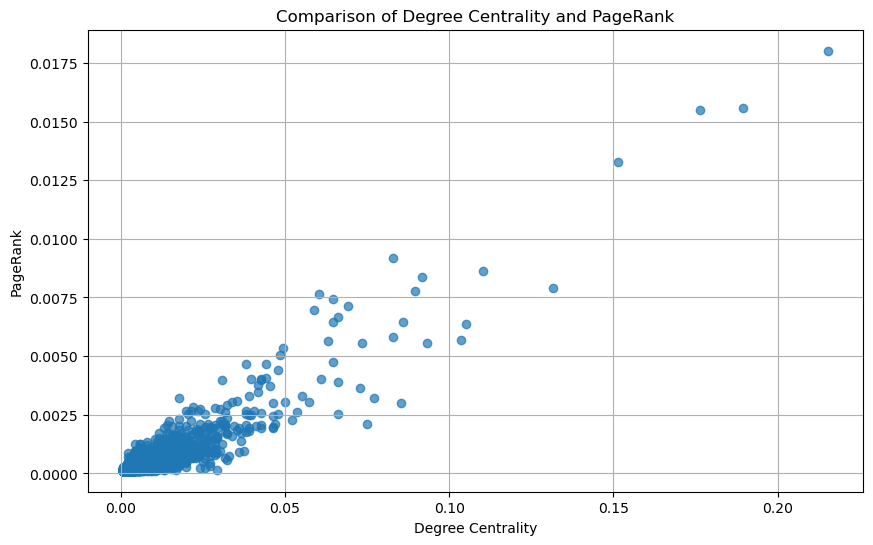

In [23]:
# Get centrality and PageRank values
degree_centrality = nx.degree_centrality(S)
page_rank = nx.pagerank(S)

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(list(degree_centrality.values()), list(page_rank.values()), alpha=0.7)
plt.xlabel("Degree Centrality")
plt.ylabel("PageRank")
plt.title("Comparison of Degree Centrality and PageRank")
plt.grid(True)
plt.show()

## Summary: Degree Centrality vs. PageRank

### Key Observations
1. **Overlap in Names**:
   - Both degree centrality and PageRank highlight many of the same philosophers (e.g., Aristotle, Kant, Plato) due to their prominence in the network.
   - Influential nodes are commonly recognized by both measures, but the rankings differ due to their distinct methodologies.

2. **Differences in Rankings**:
   - **Degree Centrality** emphasizes direct mentions (e.g., Aristotle is frequently cited by others, ranking him highly).
   - **PageRank** prioritizes nodes with high-quality incoming links, amplifying the importance of nodes cited by influential pages (e.g., Stanford Encyclopedia of Philosophy).

3. **Key Examples**:
   - Encyclopedias like *Stanford Encyclopedia* and *Routledge Encyclopedia* top the PageRank list because they are cited by highly influential philosophers but have lower degree centrality.
   - Philosophers like **Nietzsche** and **Heidegger** have higher degree centrality due to frequent direct mentions, but lower PageRank if their mentions are not from highly influential nodes.
   - Philosophers like **Adam Smith** and **Vladimir Lenin** appear in the PageRank list due to indirect influence but not in degree centrality.

## Insights
1. **Degree Centrality**:
   - Highlights philosophers with the highest number of direct mentions.
   - Reflects "local" importance in the citation network.

2. **PageRank**:
   - Captures the propagation of influence, prioritizing mentions by highly influential nodes.
   - Reflects "global" importance in the network structure.

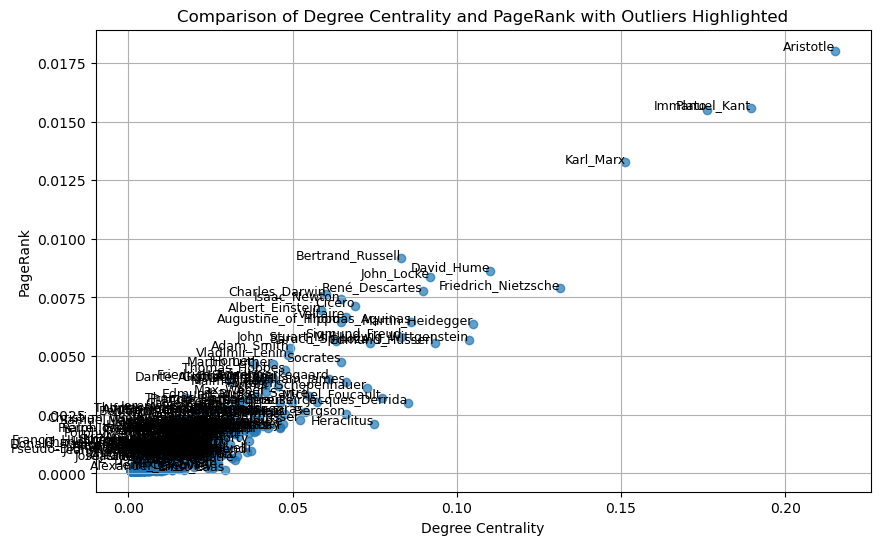

In [24]:
# Define threshold for outliers (adjust based on your dataset)
degree_values = list(degree_centrality.values())
pagerank_values = list(page_rank.values())

# Example criterion: nodes farthest from the trend line or extreme values
threshold = 0.02  # Adjust this value as needed
outliers = [node for node in degree_centrality if 
            abs(degree_centrality[node] - page_rank[node]) > threshold]

# Scatter plot with labels for outliers
plt.figure(figsize=(10, 6))
plt.scatter(degree_values, pagerank_values, alpha=0.7)

# Label outliers
for node in outliers:
    x = degree_centrality[node]
    y = page_rank[node]
    plt.text(x, y, node, fontsize=9, ha='right')

plt.xlabel("Degree Centrality")
plt.ylabel("PageRank")
plt.title("Comparison of Degree Centrality and PageRank with Outliers Highlighted")
plt.grid(True)
plt.show()


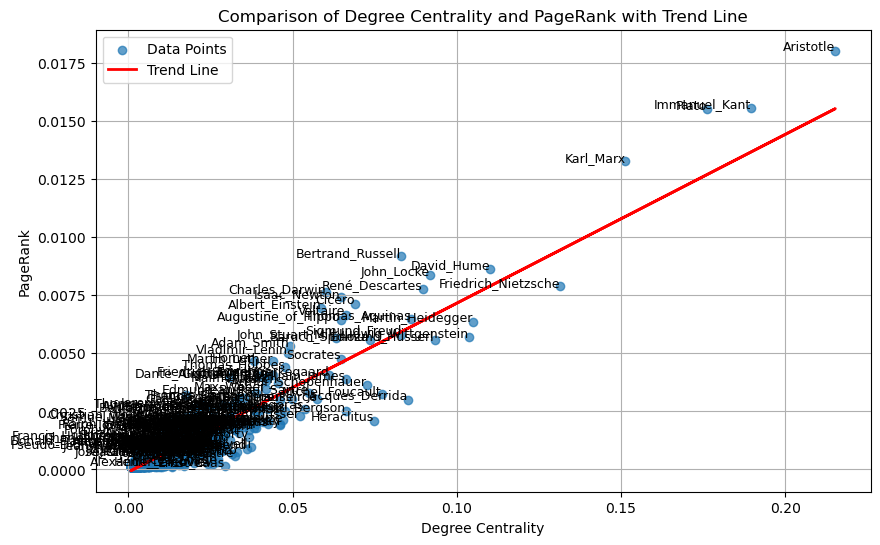

In [25]:
# Prepare data for linear regression
degree_values = np.array(list(degree_centrality.values())).reshape(-1, 1)
pagerank_values = np.array(list(page_rank.values()))

# Fit a linear regression model
model = LinearRegression()
model.fit(degree_values, pagerank_values)

# Generate predictions for the trend line
trend_line = model.predict(degree_values)

# Scatter plot with trend line
plt.figure(figsize=(10, 6))
plt.scatter(degree_values, pagerank_values, alpha=0.7, label="Data Points")
plt.plot(degree_values, trend_line, color="red", linewidth=2, label="Trend Line")

# Label outliers
threshold = 0.02  # Adjust as needed
outliers = [node for node in degree_centrality if 
            abs(degree_centrality[node] - page_rank[node]) > threshold]
for node in outliers:
    x = degree_centrality[node]
    y = page_rank[node]
    plt.text(x, y, node, fontsize=9, ha='right')

plt.xlabel("Degree Centrality")
plt.ylabel("PageRank")
plt.title("Comparison of Degree Centrality and PageRank with Trend Line")
plt.legend()
plt.grid(True)
plt.show()

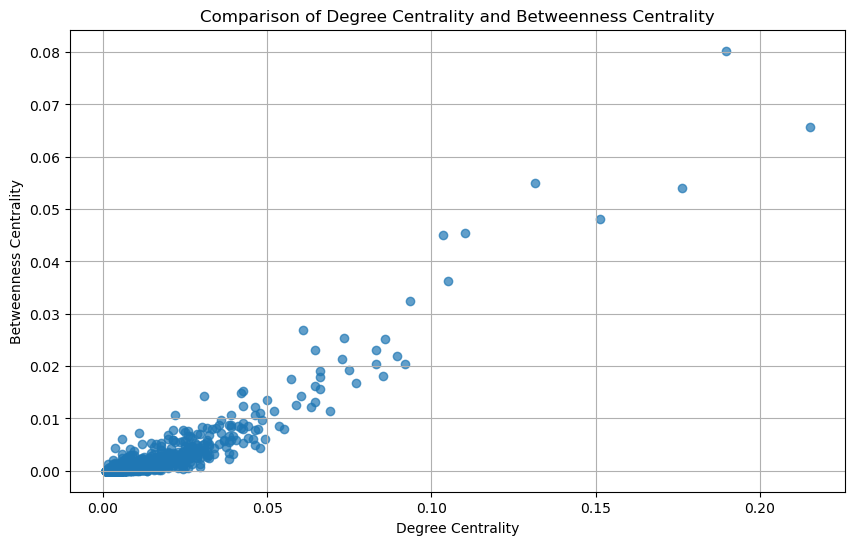

In [26]:
# plot degree centrality vs betweenness centrality
degree_centrality = nx.degree_centrality(S)
betweenness_centrality = nx.betweenness_centrality(S)

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(list(degree_centrality.values()), list(betweenness_centrality.values()), alpha=0.7)
plt.xlabel("Degree Centrality")
plt.ylabel("Betweenness Centrality")
plt.title("Comparison of Degree Centrality and Betweenness Centrality")
plt.grid(True)
plt.show()

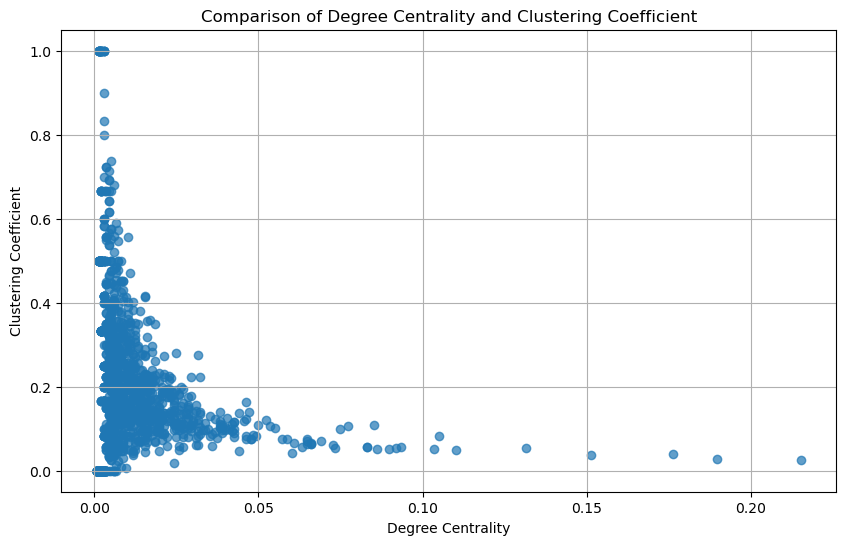

In [27]:
# compute clustering coefficient
clustering_coefficient = nx.clustering(S)

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(list(degree_centrality.values()), list(clustering_coefficient.values()), alpha=0.7)
plt.xlabel("Degree Centrality")
plt.ylabel("Clustering Coefficient")
plt.title("Comparison of Degree Centrality and Clustering Coefficient")
plt.grid(True)
plt.show()

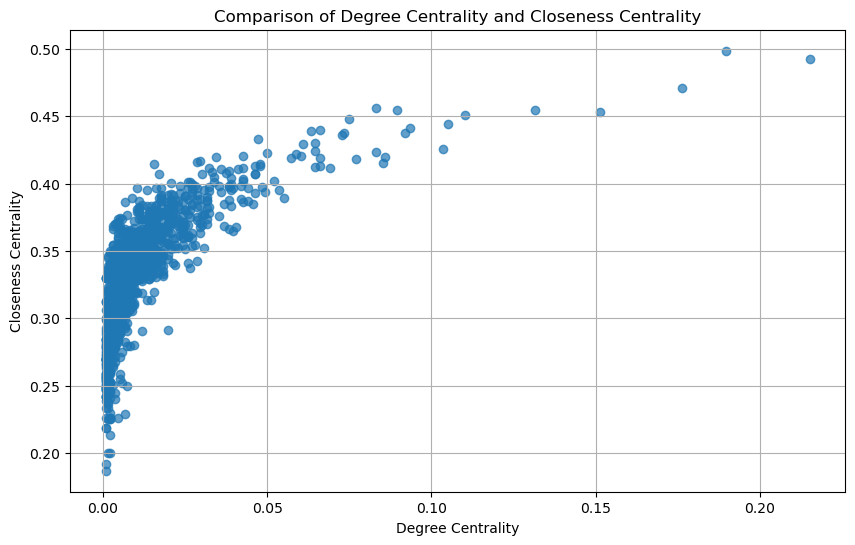

In [28]:
# plot degree centrality vs closeness centrality
degree_centrality = nx.degree_centrality(S)
closeness_centrality = nx.closeness_centrality(S_undirected)

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(list(degree_centrality.values()), list(closeness_centrality.values()), alpha=0.7)
plt.xlabel("Degree Centrality")
plt.ylabel("Closeness Centrality")
plt.title("Comparison of Degree Centrality and Closeness Centrality")
plt.grid(True)
plt.show()

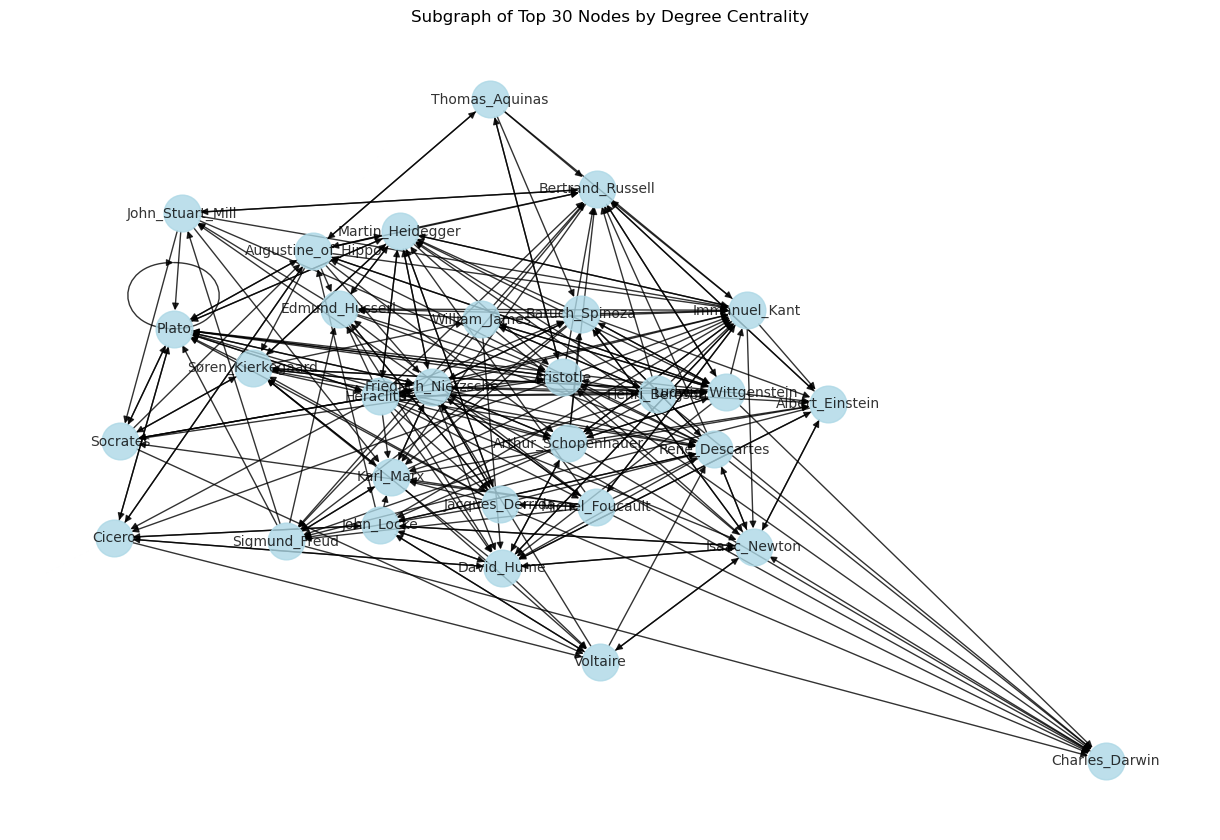

In [40]:
# Step 1: Extract the top 30 nodes by degree centrality
top_30_degree_nodes = [node for node, _ in sorted_centrality[:30]]

# Step 2: Create the subgraph with only these nodes
subgraph = S.subgraph(top_30_degree_nodes)

# Step 3: Visualize the subgraph
plt.figure(figsize=(12, 8))
nx.draw(subgraph, with_labels=True, node_size=700, node_color="lightblue", alpha=0.8, font_size=10)
plt.title("Subgraph of Top 30 Nodes by Degree Centrality")
plt.show()

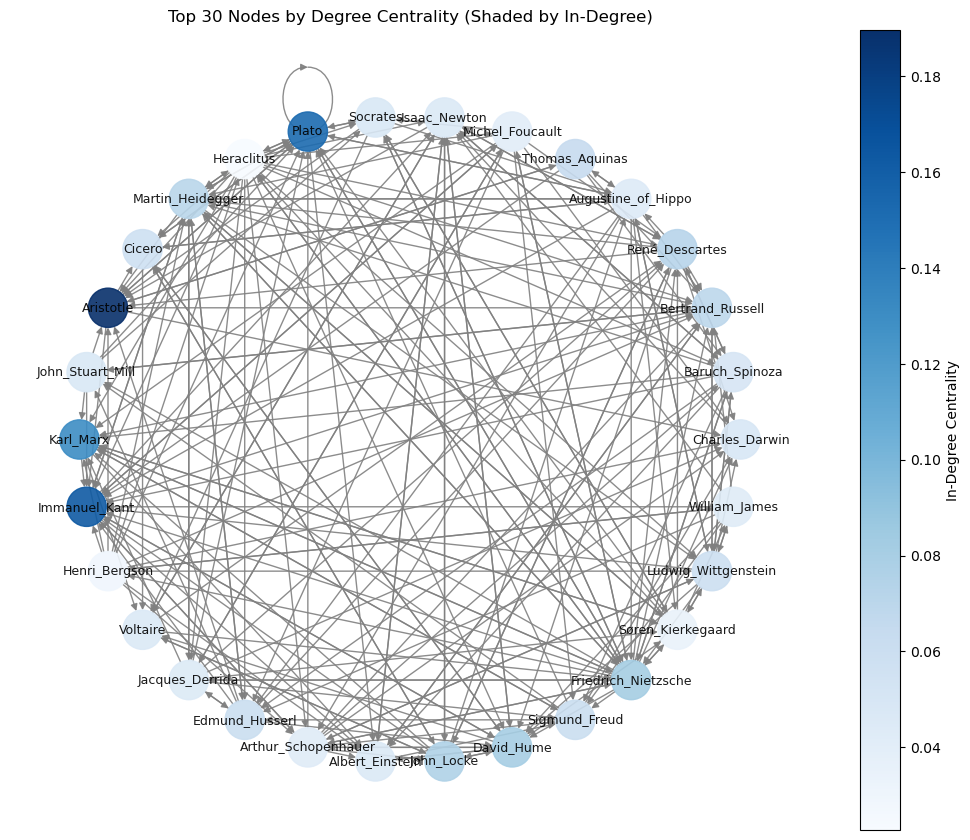

In [44]:
# Step 1: Extract the top 30 nodes by degree centrality
top_30_degree_nodes = [node for node, _ in sorted_centrality[:30]]

# Step 2: Create the subgraph
subgraph = S.subgraph(top_30_degree_nodes)

# Step 3: Calculate in-degree centrality for coloring
in_degree_centrality = nx.in_degree_centrality(S)  # Use the original graph's in-degree centrality
node_colors = [in_degree_centrality[node] for node in subgraph.nodes()]

# Step 4: Visualize with a circular layout
plt.figure(figsize=(10, 8))
pos = nx.circular_layout(subgraph)  # Circular layout
nx.draw(
    subgraph, pos, with_labels=True, 
    node_color=node_colors, cmap=plt.cm.Blues, 
    edge_color="gray",
    node_size=800, alpha=0.9, font_size=9, font_color="black"
)

plt.title("Top 30 Nodes by Degree Centrality (Shaded by In-Degree)")
sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues)
sm.set_array(node_colors)
plt.colorbar(sm, ax=plt.gca(), label="In-Degree Centrality")
plt.show()


In [45]:
#print nodes with highest degree centrality
sorted_centrality = sorted(nx.pagerank(subgraph).items(), key=lambda x: x[1], reverse=True)
for node, centrality in sorted_centrality:
    print(f"Node: {node}, Degree Centrality: {centrality:.4f}")

Node: Isaac_Newton, Degree Centrality: 0.0739
Node: David_Hume, Degree Centrality: 0.0559
Node: Immanuel_Kant, Degree Centrality: 0.0533
Node: Albert_Einstein, Degree Centrality: 0.0527
Node: Bertrand_Russell, Degree Centrality: 0.0525
Node: Plato, Degree Centrality: 0.0468
Node: Friedrich_Nietzsche, Degree Centrality: 0.0448
Node: Karl_Marx, Degree Centrality: 0.0409
Node: René_Descartes, Degree Centrality: 0.0396
Node: John_Locke, Degree Centrality: 0.0384
Node: Aristotle, Degree Centrality: 0.0380
Node: Voltaire, Degree Centrality: 0.0375
Node: Martin_Heidegger, Degree Centrality: 0.0363
Node: Augustine_of_Hippo, Degree Centrality: 0.0326
Node: Sigmund_Freud, Degree Centrality: 0.0323
Node: Ludwig_Wittgenstein, Degree Centrality: 0.0314
Node: Søren_Kierkegaard, Degree Centrality: 0.0310
Node: Charles_Darwin, Degree Centrality: 0.0296
Node: Cicero, Degree Centrality: 0.0282
Node: Baruch_Spinoza, Degree Centrality: 0.0276
Node: John_Stuart_Mill, Degree Centrality: 0.0265
Node: Arthur_

In [46]:
philosopher_dates = {
    "Isaac_Newton": 1643,
    "Immanuel_Kant": 1724,
    "Friedrich_Nietzsche": 1844,
    "Plato": -428,
    "David_Hume": 1711,
    "Bertrand_Russell": 1872,
    "Karl_Marx": 1818,
    "René_Descartes": 1596,
    "Martin_Heidegger": 1889,
    "John_Locke": 1632,
    "Aristotle": -384,
    "Voltaire": 1694,
    "Augustine_of_Hippo": 354,
    "Ludwig_Wittgenstein": 1889,
    "Søren_Kierkegaard": 1813,
    "Charles_Darwin": 1809,
    "Cicero": -106,
    "Baruch_Spinoza": 1632,
    "Arthur_Schopenhauer": 1788,
    "John_Stuart_Mill": 1806,
    "Sigmund_Freud": 1856,
    "Edmund_Husserl": 1859,
    "Socrates": -470,
    "Heraclitus": -535,
    "Michel_Foucault": 1926,
    "Jacques_Derrida": 1930,
    "Thomas_Aquinas": 1225,
    "William_James": 1842,
    "Henri_Bergson": 1859,
}


In [47]:
import random

def random_walk(graph, start_node, num_steps=10):
    """Simulate a random walk to study influence flow."""
    current_node = start_node
    path = [current_node]

    for _ in range(num_steps):
        neighbors = list(graph.successors(current_node))  # Directed graph: successors
        if not neighbors:
            break  # Stop if no successors
        current_node = random.choice(neighbors)
        path.append(current_node)

    return path

# Simulate a random walk starting from Aristotle
start_node = "Aristotle"
path = random_walk(S, start_node, num_steps=15)
print(f"Influence path starting from {start_node}:", " → ".join(path))


Influence path starting from Aristotle: Aristotle → Jean_Buridan → John_Philoponus → Avicenna → Porphyry_(philosopher) → Augustine_of_Hippo → Martin_Heidegger → Nicolai_Hartmann → Vladimir_Solovyov_(philosopher) → Plotinus → Ammonius_Saccas → Aristotle → Plato → Albert_Einstein → Isaac_Newton → Pierre_Louis_Maupertuis


In [51]:
# Compute effective size for each node
effective_sizes = {node: effective_size(S, node) for node in S.nodes()}
sorted_effective_sizes = sorted(effective_sizes.items(), key=lambda x: x[1], reverse=True)

# Top philosophers by effective size
print("Top philosophers by effective size (structural holes):")
for node, size in sorted_effective_sizes[:10]:
    print(f"{node}: {size:.2f}")


Top philosophers by effective size (structural holes):
Heraclitus: 63.85
Friedrich_Nietzsche: 63.09
Ludwig_Wittgenstein: 56.20
Jacques_Derrida: 47.07
Henri_Bergson: 47.00
Michel_Foucault: 43.38
Edmund_Husserl: 40.32
Martin_Heidegger: 40.02
David_Hume: 36.65
Arthur_Schopenhauer: 36.60


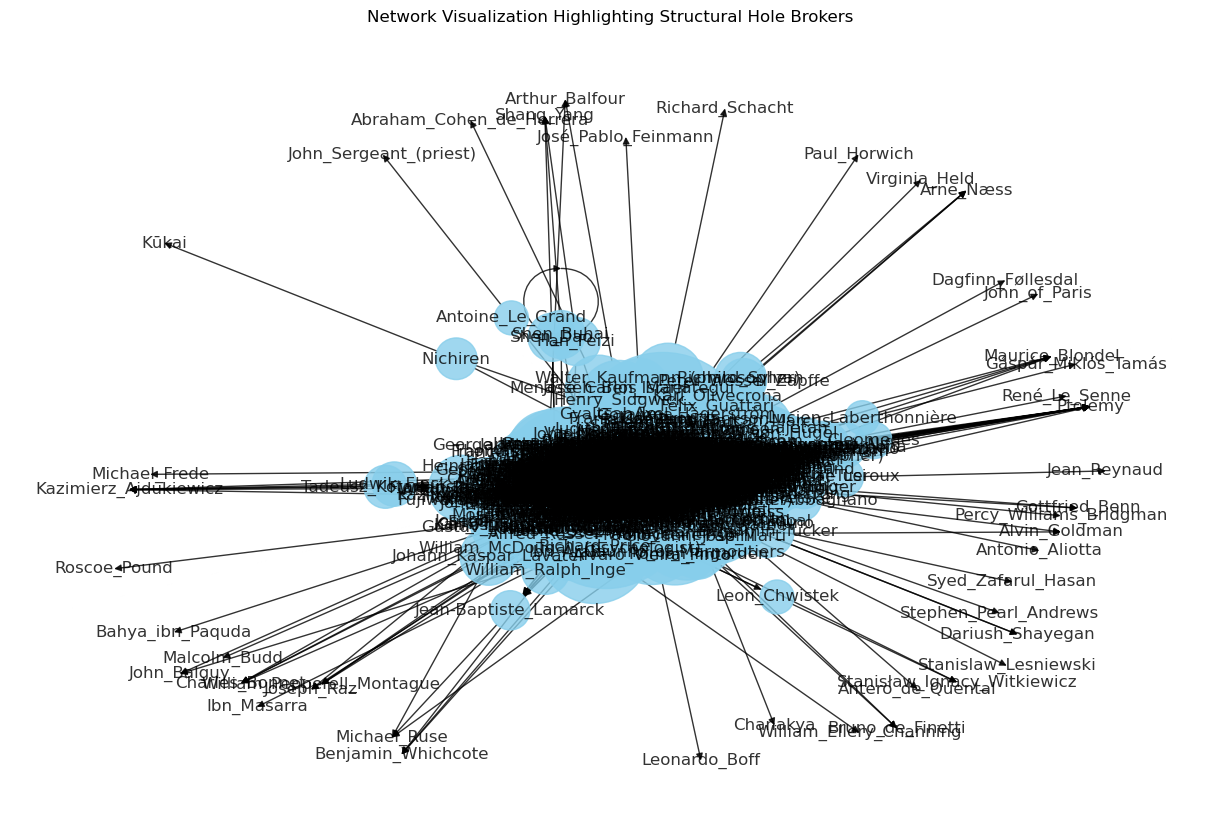

In [52]:
# Scale node sizes by effective size
node_sizes = [effective_sizes[node] * 300 for node in S.nodes()]

plt.figure(figsize=(12, 8))
nx.draw(S, with_labels=True, node_size=node_sizes, node_color="skyblue", alpha=0.8)
plt.title("Network Visualization Highlighting Structural Hole Brokers")
plt.show()
